In [3]:
from scipy import stats
import numpy as np
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss

from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML,display
import tabulate

from ast import literal_eval as make_tuple

from os import listdir
from os.path import isfile, join, splitext, basename
import csv
import itertools
import glob
from copy import deepcopy

from util import csv_length

%matplotlib inline

c:\program files\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_path = './data/deviation/'
t1_list = glob.glob(data_path + '*_t1.csv')
t2_list = glob.glob(data_path + '*_t2.csv')
com_list = glob.glob(data_path + '*_com.csv')

t1_num_list = [csv_length(data) for data in t1_list]
t2_num_list = [csv_length(data) for data in t2_list]
com_num_list = [csv_length(data) for data in com_list]

In [3]:
def ingest(data, nums):
    tmp = pd.read_csv(data, names = [i for i in range(nums)])
    tmp_sers = [tmp[i].dropna() for i in range(nums)]
    
    tmp_chkpoints = [ser[:ser[ser.str.contains('Score')].index[0]] for ser in tmp_sers]
    tmp_datas = [ser[ser[ser.str.contains('Score')].index[0]+1:] for ser in tmp_sers]
    tmp_scores = [ser[ser[ser.str.contains('Score')].index[0]] for ser in tmp_sers]
    
    return tmp_chkpoints, tmp_datas, tmp_scores

def make_arrays(sers):
    ret = [ser.apply(lambda x: np.array(make_tuple(x))) for ser in sers]
    return ret

def refine(sers):
    ret = [ser[(ser.apply(lambda x: x[2]) >= 0) & (ser.apply(lambda x: x[2]) <= 600)].reset_index(drop=True) for ser in sers]
    return ret
    

def find_dist(chkpoint, data):
    res_dict = {}
    res_list = []

    for i in range(len(chkpoint)):
        idx = min(range(len(data)), key=lambda j: abs(data[j][2]-chkpoint[i][2]))
        minidx = -5
        maxidx = 5
        if idx < 5:
            minidx = -idx
        if idx > len(data) - 5:
            maxidx = len(data) - idx
        new_idxs = np.arange(minidx, maxidx) + idx
        res_dict[i] = data.loc[new_idxs].values

    for key in res_dict.keys():
        for item in res_dict[key]:
            res_list.append(np.linalg.norm(chkpoint[key][:2] - item[:2]))
            
    return np.mean(res_list)

def score_to_list(scores):
    return [int(score.split(':')[-1]) for score in scores]

def ingest2(data, num):
    tmp = pd.read_csv(data, names=[i for i in range(num)])
    return [[0, tmp[column].apply(lambda x: int(x.split(':')[-1])).values[0]] for column in tmp]

def make_result(data, nums):
    chkpoints, datas, scores = ingest(data, nums)
    chkpoints, datas = make_arrays(chkpoints), make_arrays(datas)
    chkpoints, datas = refine(chkpoints), refine(datas)
    score_list = score_to_list(scores)
    result = [[find_dist(chkpoints[i], datas[i]), score_list[i]] for i in range(nums)]
    return result

In [4]:
t1_res_dict = {splitext(basename(data))[0]: make_result(data, nums) for data, nums in zip(t1_list, t1_num_list)} 
t2_res_dict = {splitext(basename(data))[0]: ingest2(data, nums) for data, nums in zip(t2_list, t2_num_list)}
com_res_dict = {splitext(basename(data))[0]: make_result(data, nums) for data, nums in zip(com_list, com_num_list)}

In [5]:
T1_df = pd.DataFrame(columns=['Participants No.', 'Task', 'Distance', 'Score', 'Trial'])
for key in t1_res_dict.keys():
    for i in range(len(t1_res_dict[key]))[::-1]:
        T1_df.loc[-1] = [key.split('_')[0].split('p')[-1], 'T1', float(t1_res_dict[key][i][0]), float(t1_res_dict[key][i][1]), i+1]
        T1_df.index = T1_df.index+1
        T1_df = T1_df.sort_index()
    
T2_df = pd.DataFrame(columns=['Participants No.', 'Task', 'Distance', 'Score', 'Trial'])
for key in list(t2_res_dict.keys()):
    for i in range(len(t2_res_dict[key]))[::-1]:
        T2_df.loc[-1] = [key.split('_')[0].split('p')[-1], 'T2', float(t2_res_dict[key][i][0]), float(t2_res_dict[key][i][1]), i+1]
        T2_df.index = T2_df.index+1
        T2_df = T2_df.sort_index()
    
COM_df = pd.DataFrame(columns=['Participants No.', 'Task', 'Distance', 'Score', 'Trial'])
for key in com_res_dict.keys():
    for i in range(len(com_res_dict[key]))[::-1]:
        COM_df.loc[-1] = [key.split('_')[0].split('p')[-1], 'COM', float(com_res_dict[key][i][0]), float(com_res_dict[key][i][1]), i+1]
        COM_df.index = COM_df.index+1
        COM_df = COM_df.sort_index()

In [6]:
df = pd.read_csv('./data/data.csv')
T1_df1 = df[df['Task'] == 'T1'].reset_index(drop=True)
T2_df1 = df[df['Task'] == 'T2'].reset_index(drop=True)
COM_df1 = df[df['Task'] == 'COM'].reset_index(drop=True)

In [7]:
T1_df = T1_df.append(T1_df1[T1_df1['Participants No.'] == 1], ignore_index=True)
T2_df = T2_df.append(T2_df1[T2_df1['Participants No.'] == 1], ignore_index=True)
COM_df = COM_df.append(COM_df1[COM_df1['Participants No.'] == 1], ignore_index=True)

In [8]:
T1_df.head()

,Participants No.,Task,Distance,Score,Trial
0,9,T1,5.457101,0.0,1
1,9,T1,6.247435,0.0,2
2,9,T1,10.802543,0.0,3
3,9,T1,4.176466,0.0,4
4,9,T1,3.817076,0.0,5


In [9]:
T2_df.head()

,Participants No.,Task,Distance,Score,Trial
0,9,T2,0.0,40.0,1
1,9,T2,0.0,40.0,2
2,9,T2,0.0,39.0,3
3,9,T2,0.0,40.0,4
4,9,T2,0.0,38.0,5


In [10]:
COM_df.head()

,Participants No.,Task,Distance,Score,Trial
0,9,COM,5.909593,29.0,1
1,9,COM,7.713701,16.0,2
2,9,COM,8.130159,23.0,3
3,9,COM,9.193558,20.0,4
4,9,COM,6.293320,23.0,5


### Visualization

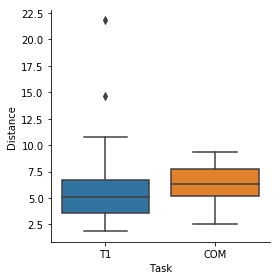

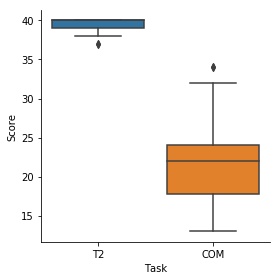

In [11]:
distance_df = pd.concat([T1_df[['Task','Distance']], COM_df[['Task','Distance']]])
score_df = pd.concat([T2_df[['Task', 'Score']], COM_df[['Task', 'Score']]])
ax = sns.factorplot(x='Task', y='Distance', data=distance_df, kind='box')
ax = sns.factorplot(x='Task', y='Score', data=score_df, kind='box')

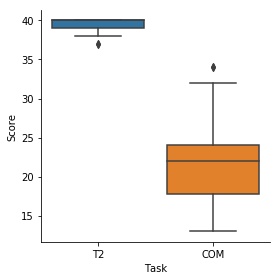

In [12]:
score_df = pd.concat([T2_df[['Task', 'Score']], COM_df[['Task', 'Score']]])
score_df['Score'] = score_df['Score'].astype(float)
ax = sns.factorplot(x='Task', y='Score', data=score_df, kind='box')

### T-Test

In [13]:
print('Distance Average, T1: %.3f' % np.mean(T1_df['Distance']))
print('Distance Average, COM: %.3f' % np.mean(COM_df['Distance']))

Distance Average, T1: 5.863
Distance Average, COM: 6.314


In [14]:
print('Distance, T1 var %.3f' % np.std(T1_df['Distance']))
print('Distance, COM var %.3f' % np.std(COM_df['Distance']))

Distance, T1 var 3.414
Distance, COM var 1.771


In [15]:
tTestResult = stats.ttest_ind(T1_df['Distance'], COM_df['Distance'], equal_var=False)
print("The T-statistic and p-value between T1 and COM not assuming equal variances is %.3f and %.3f" % tTestResult)

The T-statistic and p-value between T1 and COM not assuming equal variances is -0.811 and 0.420


In [16]:
print('Score Average, T2: %.3f' % np.mean(T2_df['Score']))
print('Score Average, COM: %.3f' % np.mean(COM_df['Score']))

Score Average, T2: 39.436
Score Average, COM: 21.479


In [17]:
print('Score, T2 var %.3f' % np.std(T2_df['Score']))
print('Score, COM var %.3f' % np.std(COM_df['Score']))

Score, T2 var 0.804
Score, COM var 4.996


In [18]:
tTestResult = stats.ttest_ind(T2_df['Score'], COM_df['Score'], equal_var=False)
print("The T-statistic and p-value between task T2 and COM not assuming equal variances is %.3f and %.3f" % tTestResult)

The T-statistic and p-value between task T2 and COM not assuming equal variances is 24.369 and 0.000


### Cronbach's Alpha

In [4]:
def CronbachAlpha(items, rev=None):
    df = items.copy(deep=True)
    if rev is not None:
        for pair in rev:
            df[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
    
    itemvars = np.var(df, axis=0)
    nitems = len(df)
    slist = np.sum(df, axis=1)
    sumvar = np.var(slist)
    varsum = np.sum(itemvars)

    Calpha = ((nitems)/(nitems-1.)) * (1-(varsum/sumvar))
    
    return Calpha

In [5]:
def ingest(file):
    df = pd.read_csv(file).dropna(axis=1)
    vreq_df = df.filter(regex=("VREQ*"))
    spes_df = df.filter(regex=("SPES*"))
    tlx_df = df.filter(regex=("TLX*"))
    
    return [vreq_df, spes_df, tlx_df]

In [6]:
t1 = ingest('./data/T1.csv')
t2 = ingest('./data/T2.csv')
com = ingest('./data/combined.csv')

In [7]:
t1_with_sum = deepcopy(t1)
t2_with_sum = deepcopy(t2)
com_with_sum = deepcopy(com)

In [23]:
# t1[0], t2[0], com[0] = t1[0].drop('VREQSUM', axis=1), t2[0].drop('VREQSUM', axis=1), com[0].drop('VREQSUM', axis=1)
# t1[1], t2[1], com[1] = t1[1].drop('SPESSUM', axis=1), t2[1].drop('SPESSUM', axis=1), com[1].drop('SPESSUM', axis=1)
# t1[2], t2[2], com[2] = t1[2].drop('TLX-SUM', axis=1), com[2].drop('TLX-SUM', axis=1), com[2].drop('TLX-SUM', axis=1),

In [9]:
table = [['', 'VREQ', 'SPES', 'TLX'],
         ['T1', round(CronbachAlpha(t1[0], [['VREQ6', 6]]), 3), round(CronbachAlpha(t1[1]), 3), round(CronbachAlpha(t1[2], [['TLX-Perf', 8]]), 3)],
         ['T2', round(CronbachAlpha(t2[0], [['VREQ6', 6]]), 3), round(CronbachAlpha(t2[1]), 3), round(CronbachAlpha(t2[2], [['TLX-Perf', 8]]), 3)],
         ['T3', round(CronbachAlpha(com[0], [['VREQ6', 6]]), 3), round(CronbachAlpha(com[1]), 3), round(CronbachAlpha(com[2], [['TLX-Perf', 8]]), 3)],
         ['ALL', round(CronbachAlpha(pd.concat([t1[0], t2[0], com[0]], axis=0), [['VREQ6', 6]]), 3), round(CronbachAlpha(pd.concat([t1[1], t2[1], com[1]], axis=0)), 3), round(CronbachAlpha(pd.concat([t1[2], t2[2], com[2]], axis=0), [['TLX-Perf', 8]]), 3)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,VREQ,SPES,TLX
T1,0.762,0.37,0.303
T2,0.701,0.734,0.146
T3,0.784,0.324,0.511
ALL,0.667,0.625,0.722


### Visualization

In [10]:
def concatenate(l, label):
    assert(len(l) == len(label))
    li = []
    for i in range(len(l)):
        temp = l[i].copy(deep=True)
        temp['Task'] = pd.Series([label[i]] * len(temp))
        li.append(temp)
        
    return pd.concat(li)

In [11]:
label = ['T1', 'T2', 'COM']
vreq_df = concatenate([t1_with_sum[0], t2_with_sum[0], com_with_sum[0]], label)
spes_df = concatenate([t1_with_sum[1], t2_with_sum[1], com_with_sum[1]], label)
tlx_df = concatenate([t1_with_sum[2], t2_with_sum[2], com_with_sum[2]], label)

In [12]:
tlx_df.columns

Index(['TLX-Mental', 'TLX-Physical', 'TLX-Perf', 'TLX-Effort',
       'TLX-Frustration', 'Task'],
      dtype='object')

In [14]:
dfs = [vreq_df, spes_df, tlx_df]
df_labels = [['VREQ1', 'VREQ2', 'VREQ3', 'VREQ4', 'VREQ5', 'VREQ6', 'VREQ7'], 
             ['SPES1', 'SPES2', 'SPES3', 'SPES4'], 
             ['TLX-Mental', 'TLX-Physical', 'TLX-Perf', 'TLX-Effort', 'TLX-Frustration']]
for i in range(len(dfs)):
    print(df_labels[i][0])
    for l in label:
        tmp = dfs[i][dfs[i]['Task'] == l][df_labels[i]]
        print(np.mean(tmp, axis=0))
        print(np.std(tmp, axis=0))
        print(stats.iqr(tmp, axis=0))
        print('-' * 40)

VREQ1
VREQ1    3.583333
VREQ2    4.416667
VREQ3    3.750000
VREQ4    3.500000
VREQ5    4.500000
VREQ6    3.333333
VREQ7    3.250000
dtype: float64
VREQ1    0.640095
VREQ2    0.862007
VREQ3    0.924211
VREQ4    0.866025
VREQ5    0.500000
VREQ6    1.105542
VREQ7    0.595119
dtype: float64
[1.   1.   0.25 1.   1.   2.   1.  ]
----------------------------------------
VREQ1    4.166667
VREQ2    4.416667
VREQ3    4.250000
VREQ4    3.916667
VREQ5    3.166667
VREQ6    1.666667
VREQ7    3.666667
dtype: float64
VREQ1    0.897527
VREQ2    0.953794
VREQ3    0.721688
VREQ4    1.320248
VREQ5    1.343710
VREQ6    1.105542
VREQ7    0.942809
dtype: float64
[1.   1.   1.   2.   2.25 1.   1.  ]
----------------------------------------
VREQ1    3.083333
VREQ2    4.333333
VREQ3    3.583333
VREQ4    3.416667
VREQ5    3.916667
VREQ6    4.083333
VREQ7    3.500000
dtype: float64
VREQ1    0.862007
VREQ2    0.623610
VREQ3    1.037492
VREQ4    1.037492
VREQ5    0.759203
VREQ6    1.037492
VREQ7    0.645497
dtype: 

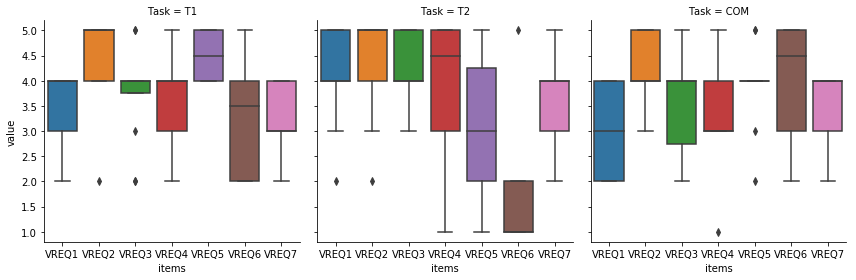

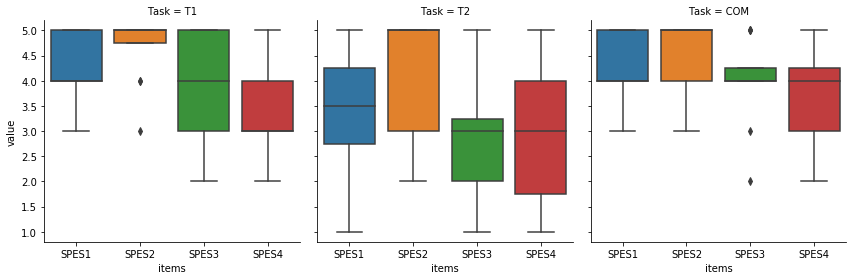

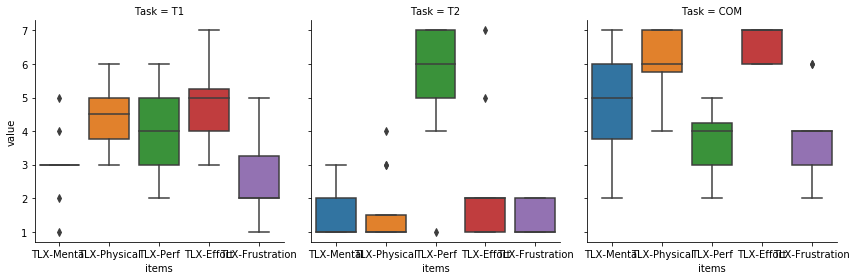

In [15]:
ax = sns.factorplot(x='items', y='value', col='Task', data=vreq_df.melt(id_vars=['Task'], var_name='items'), kind='box')
ax = sns.factorplot(x='items', y='value', col='Task', data=spes_df.melt(id_vars=['Task'], var_name='items'), kind='box')
ax = sns.factorplot(x='items', y='value', col='Task', data=tlx_df.melt(id_vars=['Task'], var_name='items'), kind='box')

### ANOVA

In [16]:
def onewayAnova(df, columns, rev=None):
    ret = []
    temp = df.copy(deep=True)
    if rev is not None:
        for pair in rev:
            temp[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
            
    for column in columns:
        tmpSeries = temp[[column, 'Task']]
        ret.append([column, stats.f_oneway(tmpSeries[tmpSeries['Task'] == 'T1'][column], 
                                           tmpSeries[tmpSeries['Task'] == 'T2'][column],
                                           tmpSeries[tmpSeries['Task'] == 'COM'][column])])
        
    return ret
        

In [17]:
vreq_columns = [x for x in vreq_df.columns if x is not 'Task']
spes_columns = [x for x in spes_df.columns if x is not 'Task']
tlx_columns = [x for x in tlx_df.columns if x is not 'Task']

vreq_stats = onewayAnova(vreq_df, vreq_columns, [['VREQ6', 6]])
spes_stats = onewayAnova(spes_df, spes_columns)
tlx_stats = onewayAnova(tlx_df, tlx_columns, [['TLX-Perf', 8]])

In [18]:
def make_table_elem(stats):
    li = []
    for stat in stats:
        li.append([stat[0], round(stat[1][0], 3), round(stat[1][1], 3)])
        
    return [['', 'F-value', 'p-value']] + li

In [19]:
display(HTML(tabulate.tabulate(make_table_elem(vreq_stats), tablefmt='html')))

,F-value,p-value
VREQ1,4.954,0.013
VREQ2,0.037,0.963
VREQ3,1.62,0.213
VREQ4,0.663,0.522
VREQ5,5.602,0.008
VREQ6,14.341,0.0
VREQ7,0.874,0.427


In [20]:
display(HTML(tabulate.tabulate(make_table_elem(spes_stats), tablefmt='html')))

,F-value,p-value
SPES1,3.123,0.057
SPES2,1.487,0.241
SPES3,5.079,0.012
SPES4,1.58,0.221


In [21]:
display(HTML(tabulate.tabulate(make_table_elem(tlx_stats), tablefmt='html')))

,F-value,p-value
TLX-Mental,22.678,0.0
TLX-Physical,55.333,0.0
TLX-Perf,6.94,0.003
TLX-Effort,34.321,0.0
TLX-Frustration,20.494,0.0


### Post-Hoc(Tukey)

In [37]:
def post_hoc_tukey(df, columns, rev=None):
    temp = df.copy(deep=True)
    if rev is not None:
        for pair in rev:
            temp[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
            
    for column in columns:
        res = pairwise_tukeyhsd(df[column], df['Task'])
        print('Tukey post-hoc of %s' % column)
        display(res.summary())   

In [38]:
post_hoc_tukey(vreq_df, vreq_columns, [['VREQ9', 6]])

Tukey post-hoc of VREQ1


group1,group2,meandiff,lower,upper,reject
COM,T1,0.5,-0.3452,1.3452,False
COM,T2,1.0833,0.2381,1.9285,True
T1,T2,0.5833,-0.2619,1.4285,False


Tukey post-hoc of VREQ5


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0833,-0.7797,0.9463,False
COM,T2,0.0833,-0.7797,0.9463,False
T1,T2,0.0,-0.863,0.863,False


Tukey post-hoc of VREQ6


group1,group2,meandiff,lower,upper,reject
COM,T1,0.1667,-0.779,1.1123,False
COM,T2,0.6667,-0.279,1.6123,False
T1,T2,0.5,-0.4456,1.4456,False


Tukey post-hoc of VREQ7


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0833,-1.0578,1.2244,False
COM,T2,0.5,-0.6411,1.6411,False
T1,T2,0.4167,-0.7244,1.5578,False


Tukey post-hoc of VREQ8


group1,group2,meandiff,lower,upper,reject
COM,T1,0.5833,-0.3965,1.5632,False
COM,T2,-0.75,-1.7298,0.2298,False
T1,T2,-1.3333,-2.3132,-0.3535,True


Tukey post-hoc of VREQ9


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.75,-1.8833,0.3833,False
COM,T2,-2.4167,-3.55,-1.2834,True
T1,T2,-1.6667,-2.8,-0.5334,True


Tukey post-hoc of VREQ10


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.25,-1.0281,0.5281,False
COM,T2,0.1667,-0.6114,0.9448,False
T1,T2,0.4167,-0.3614,1.1948,False


Tukey post-hoc of VREQSUM


group1,group2,meandiff,lower,upper,reject
COM,T1,0.2742,-0.3734,0.9217,False
COM,T2,0.5958,-0.0517,1.2434,False
T1,T2,0.3217,-0.3259,0.9692,False


In [39]:
post_hoc_tukey(spes_df, spes_columns)

Tukey post-hoc of SPES1


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0833,-0.9119,1.0786,False
COM,T2,-0.8333,-1.8286,0.1619,False
T1,T2,-0.9167,-1.9119,0.0786,False


Tukey post-hoc of SPES2


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0833,-0.8142,0.9809,False
COM,T2,-0.5,-1.3975,0.3975,False
T1,T2,-0.5833,-1.4809,0.3142,False


Tukey post-hoc of SPES3


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.1667,-1.2116,0.8782,False
COM,T2,-1.25,-2.2949,-0.2051,True
T1,T2,-1.0833,-2.1282,-0.0384,True


Tukey post-hoc of SPES4


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.3333,-1.491,0.8243,False
COM,T2,-0.8333,-1.991,0.3243,False
T1,T2,-0.5,-1.6576,0.6576,False


Tukey post-hoc of SPESSUM


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.0833,-0.8747,0.708,False
COM,T2,-0.8542,-1.6455,-0.0628,True
T1,T2,-0.7708,-1.5622,0.0205,False


In [40]:
post_hoc_tukey(tlx_df, tlx_columns, [['TLX-Perf', 8]])

Tukey post-hoc of TLX-Mental


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.8333,-3.0496,-0.617,True
COM,T2,-3.3333,-4.5496,-2.117,True
T1,T2,-1.5,-2.7163,-0.2837,True


Tukey post-hoc of TLX-Physical


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.5833,-2.627,-0.5396,True
COM,T2,-4.4167,-5.4604,-3.373,True
T1,T2,-2.8333,-3.877,-1.7896,True


Tukey post-hoc of TLX-Perf


group1,group2,meandiff,lower,upper,reject
COM,T1,0.3333,-1.0153,1.682,False
COM,T2,1.9167,0.568,3.2653,True
T1,T2,1.5833,0.2347,2.932,True


Tukey post-hoc of TLX-Effort


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.75,-3.0411,-0.4589,True
COM,T2,-4.3333,-5.6244,-3.0423,True
T1,T2,-2.5833,-3.8744,-1.2923,True


Tukey post-hoc of TLX-Frustration


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.25,-2.2401,-0.2599,True
COM,T2,-2.5833,-3.5735,-1.5932,True
T1,T2,-1.3333,-2.3235,-0.3432,True


Tukey post-hoc of TLX-SUM


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.25,-1.9389,-0.5611,True
COM,T2,-3.05,-3.7389,-2.3611,True
T1,T2,-1.8,-2.4889,-1.1111,True
